In [21]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


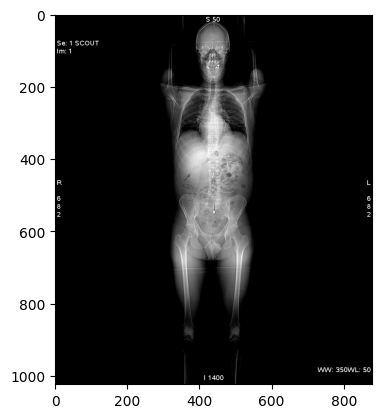

In [22]:
def load_image(path):
    return np.array(Image.open(path).convert('L'))

image_array = load_image('img/CT_ScoutView.jpg')

plt.imshow(image_array, cmap='gray')
plt.show()


# Radom transform

Function for calculating detector positions for a given angle.

In [23]:
def get_detector_positions(num_detectors, angle, emitter_pos, rows, cols, spread):
   detector_positions = []
   detector_angle = angle + np.pi / 2

   for i in range(num_detectors):
       x = emitter_pos[0] + spread * np.cos(detector_angle + (i - (num_detectors - 1) / 2) * np.pi / (num_detectors - 1))
       y = emitter_pos[1] + spread * np.sin(detector_angle + (i - (num_detectors - 1) / 2) * np.pi / (num_detectors - 1))
       detector_positions.append([x, y])
   
   return np.array(detector_positions)

Function for calculating projections for given positions of the emitter and detectors and implementation of Bresenham's algorithm.

In [24]:
def compute_projections(image_array, emitter_pos, detector_pos):
   projections = []
   rows, cols = image_array.shape

   for detector in detector_pos:
       projection = 0
       line_points = bresenham(emitter_pos, detector)
       for x, y in line_points:
           if 0 <= x < cols and 0 <= y < rows:
               projection += image_array[y, x]
       projections.append(projection)
   
   return np.array(projections)

In [25]:
def bresenham(start, end):
    x1, y1 = start
    x2, y2 = end
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    points = []
    max_it = max(dx, dy) + 1
    total = 0

    while True:
        points.append((x1, y1))
        if x1 == x2 and y1 == y2 or total > max_it:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy
        total += 1

    return points

Main Radon transform function

In [26]:
def radon_transform(image_array, num_detectors, angles, spread):
   rows, cols = image_array.shape
   sinogram = np.zeros((len(angles), num_detectors))

   for i, angle in enumerate(angles):
       emitter_pos = np.array([cols // 2, rows // 2])
       detector_pos = get_detector_positions(num_detectors, angle, emitter_pos, rows, cols, spread)
       projections = compute_projections(image_array, emitter_pos, detector_pos)
       sinogram[i] = projections
       
   return sinogram

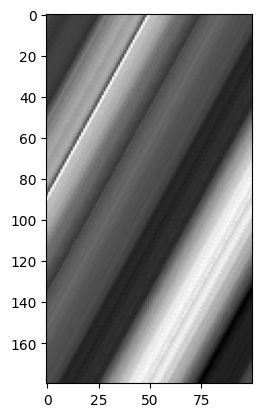

In [27]:
num_detectors = 100
angles = np.linspace(0, np.pi, 180)
spread = 100

sinogram = radon_transform(image_array, num_detectors, angles, spread)

plt.imshow(sinogram, cmap='gray')
plt.show()

In [28]:
def inverse_radon_transform(sinogram, angles, spread, rows, cols):
    image_array = np.zeros((rows, cols), dtype=np.float32)
    num_detectors = sinogram.shape[1]

    for i, angle in enumerate(angles):
        emitter_pos = np.array([cols // 2, rows // 2])
        detector_pos = get_detector_positions(num_detectors, angle, emitter_pos, rows, cols, spread)
        projections = sinogram[i]

        for j, detector in enumerate(detector_pos):
            line_points = bresenham(emitter_pos, detector)
            for x, y in line_points:
                if 0 <= x < cols and 0 <= y < rows:
                    image_array[y, x] += projections[j] / len(line_points)

    image_array = np.clip(image_array, 0, 255).astype(np.uint8)
    return image_array

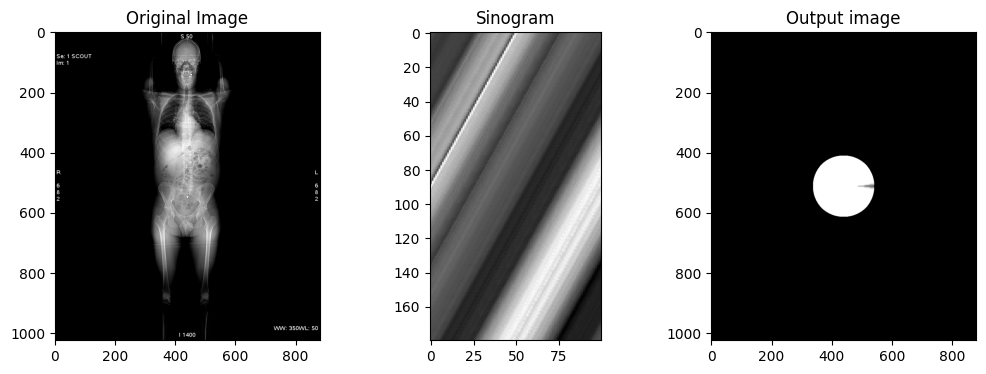

In [29]:
inverse_radon = inverse_radon_transform(sinogram, angles, spread, image_array.shape[0], image_array.shape[1])

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(sinogram, cmap='gray')
plt.title('Sinogram')

plt.subplot(1, 3, 3)
plt.imshow(inverse_radon, cmap='gray')
plt.title('Output image')

plt.show()